# BioE C142 Final Ugrad Project Checkpoint 4 - Qile Yang

Instructions: Final production mode. Multiple runs and N-fold cross-validation.

In [10]:
# notebook and python env setup
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchani
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Loading previous data and functions from checkpoints 1-3

In [11]:
# loading data and default energy computers

def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length

def load_ani_dataset(dspath):
    self_energies = torch.tensor([ # this was in the original code, but the variable isn't used?
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("../data/ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)
print(len(train_data))

691918


In [12]:
# defining the trainer

class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=l2
        )
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(self.batch_size).cache()
        train_data_len = len(train_data)
        
        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                true_energies = train_data_batch["energies"].to(device).float()
                
                # compute loss
                batch_loss = loss_func(
                    true_energies,
                    self.model((
                        train_data_batch['species'].to(device),
                        train_data_batch['coordinates'].to(device)
                    ))[1]
                )
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = len(train_data_batch) / train_data_len
                train_epoch_loss += batch_loss.item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            epochs = np.arange(self.epoch)
            ax.plot(epochs, train_loss_list, label='Train')
            ax.plot(epochs, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(self.batch_size).cache()
        data_len = len(data)
        
        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                true_energies = batch_data["energies"].to(device).float()
                _, pred_energies = self.model((
                    batch_data['species'].to(device),
                    batch_data['coordinates'].to(device)
                ))

                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)

                batch_importance = len(batch_data) / data_len
                total_loss += batch_loss.item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = (true_energies_all - pred_energies_all) * 627.5094738898777
            mae = np.mean(np.abs(hartree2kcalmol))
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()

        return total_loss

# here I'll define a helper to create the model
from collections.abc import Callable

def create_model(model_class: Callable) -> nn.Module:
    net_H = model_class()
    net_C = model_class()
    net_N = model_class()
    net_O = model_class()
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    return nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)

## Actual Checkpoint 4 Content

I'll start by defining the kfold training scheme, then use my final choice of model and final choice of hyperparameters, then training over folds and evaluating the model.

In [25]:
# construct the K fold trainer
from collections.abc import Callable
from sklearn.model_selection import KFold

def train_kfold(k: int, model_class: Callable, dataset, **kwargs) -> list[ANITrainer]:
    """
    Alternative k-fold implementation using the native .split() method
    without additional parameters.
    
    Args:
        k: Number of folds
        model_class: Class to use for creating each model
        dataset: Full dataset to split into folds
        **kwargs: Additional parameters to pass to ANITrainer
        
    Returns:
        List of trained ANITrainer objects, one for each fold
    """
    trainers = []
    dataset_size = len(dataset)
    
    # Set up k-fold cross validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    indices = np.arange(dataset_size)
    
    # Process each fold
    for fold, (train_indices, val_indices) in enumerate(kf.split(indices)):
        print(f"Training fold {fold+1}/{k}")
        train_proportion = len(train_indices) / dataset_size
        val_proportion = len(val_indices) / dataset_size
        temp_train_data, temp_val_data = dataset.split(train_proportion, val_proportion)
        shuffled_dataset = dataset.shuffle()
        train_data, val_data = shuffled_dataset.split(train_proportion, val_proportion)
        print(f"Fold {fold+1}: Training with {len(train_data)} samples, validating with {len(val_data)} samples")
        model = create_model(model_class)
        trainer = ANITrainer(model=model, **kwargs)
        trainer.train(
            train_data=train_data, 
            val_data=val_data, 
            early_stop=True, 
            draw_curve=True
        )
        trainers.append(trainer)
        # test_loss = trainer.evaluate(val_data, draw_plot=True)
        # print(f"Fold {fold+1} validation loss: {test_loss:.6f}")
    return trainers

Training over 3 folds with batch size 2048, learning rate 0.0001, no regularization, and 40 epochs.

Training fold 1/3
Fold 1: Training with 461278 samples, validating with 230640 samples
Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 40/40 [07:02<00:00, 10.56s/it]


Training fold 2/3
Fold 2: Training with 461279 samples, validating with 230639 samples
Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 40/40 [06:18<00:00,  9.46s/it]


Training fold 3/3
Fold 3: Training with 461279 samples, validating with 230639 samples
Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 40/40 [06:14<00:00,  9.35s/it]


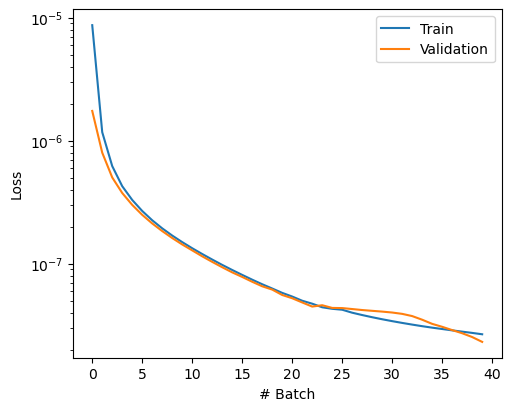

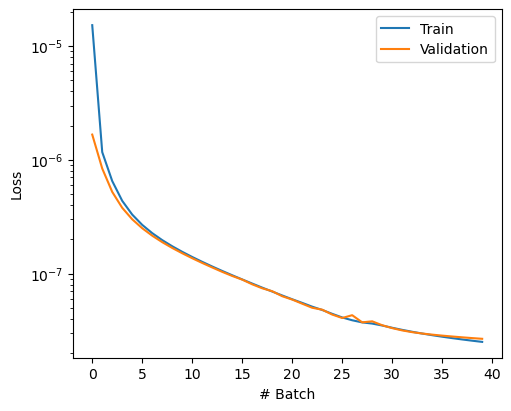

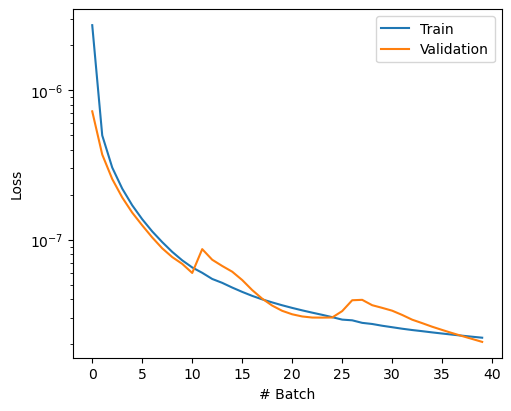

In [26]:
class FeedForwardANI(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(aev_dim, 128),
            nn.CELU(alpha=0.1),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
    
trainers = train_kfold(
    k=3, model_class=FeedForwardANI, dataset=train_data,
    batch_size=2048, learning_rate=1e-4, epoch=40, l2=0.0
)

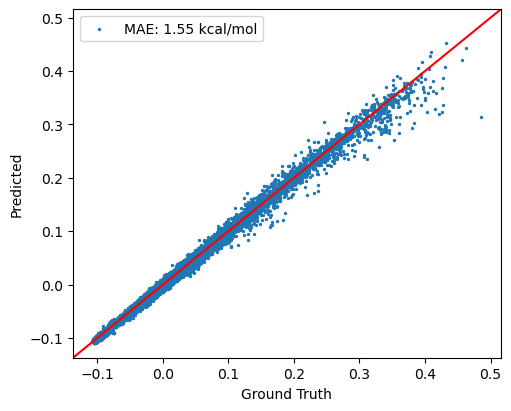

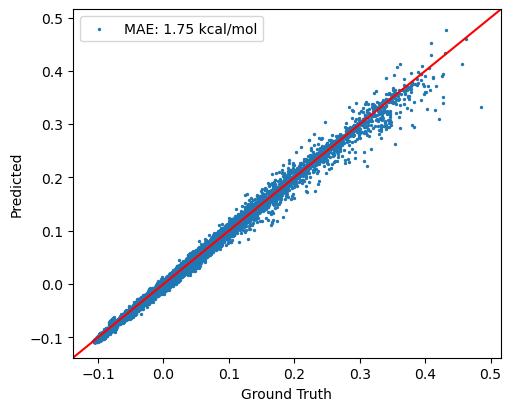

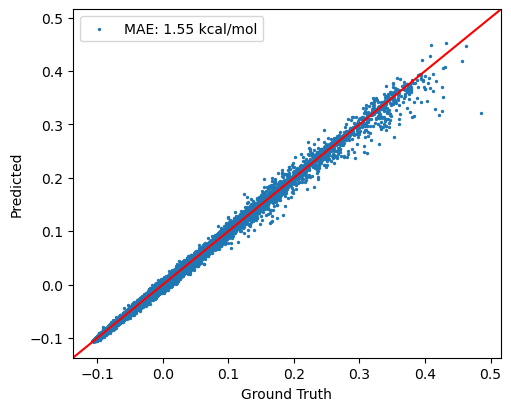

In [27]:
# evaluation of each model on the same test data

for trainer in trainers:
    trainer.evaluate(test_data, draw_plot=True)

Here I have trained this linear CELU based neural network with 3 folds of training and validation. The model is trained with a batch size of 2048, learning rate of 0.0001, no regularization, and 40 epochs. The training and validation loss are plotted above.

We see that the first two models have pretty standard training and validation loss curves, but the third model has 2 very weird validation loss mini peaks, which I have no idea why. It might be due to a weird imbalance in the testing data that was not uniformly sampled or just some outliers? But otherwise the losses in the longterm converged well for all models.

For the evaluation of generalization performance, we see that the first and last models had essentially the same MAE of 1.55 kcal/mol and the second model had slightly higher MAE at 1.75 kcal/mol. So overall all pretty decent. In a rough visual inspection we see that at the higher ends of the kcal range, there seem to be pretty similar outliers (if you can call them that, just a few extra dots) so there definetely still is room for improvement. I think to refine everything a little more in the next checkpoint I might introduce a little bit of dropout and also just train the model longer since the loss curves look like they still have a bit of optimization left in it. (probably due to Adam's decaying learning rate still having some room left)

Overall pretty decent performance across all folds.